# BreastMammaryTissueJunctionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [14]:
library(limma)
library(piggyback)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
library(R.utils)
library(statmod)

## Modeling

This analysis uses edgeR.  From the documentation, it is important to note that normalization takes the form of correction factors that enter into the statistical model. Such correction factors are usually computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

Alternatively, gene-specific correction factors can be entered into the glm functions of edgeR as offsets. In the latter case, the offset matrix will be assumed to account for all normalization issues, including sequencing depth and RNA composition.

Note that normalization in edgeR is model-based, and the original read counts are not themselves transformed. This means that users should not transform the read counts in any way before inputing them to edgeR. For example, users should not enter RPKM or FPKM val- ues to edgeR in place of read counts. Such quantities will prevent edgeR from correctly estimating the mean-variance relationship in the data, which is a crucial to the statistical strategies underlying edgeR. Similarly, users should not add artificial values to the counts before inputing them to edgeR.

edgeR is not designed to work with estimated expression levels, for example as might be output by Cufflinks. 
edgeR can work with expected counts as output by RSEM, but raw counts are still preferred. 

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.


Be sure to set your GITHUB_TOKEN, prior to downloading files

One suggestion is change it to your token and then run it then immediately change it back to this:

Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

### Did you remember?
Did you remember to delete your private github token?  Now is a good time to do so, before you save your work and checkit in inadvertantly....

In [15]:
piggyback::pb_download(
    repo = "TheJacksonLaboratory/sbas", 
    file = "SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz",
    tag  = "GTExV8.v1.0", 
    dest = "../data/")

piggyback::pb_download(
    repo = "adeslatt/sbas_test", 
    file = "rmats_final.se.jc.ijc.txt.gz",
    tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
    dest = "../data/")

piggyback::pb_download(
    repo = "adeslatt/sbas_test", 
    file = "rmats_final.se.jc.sjc.txt.gz",
    tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
    dest = "../data/")

ijc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz") 
sjc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz") 
meta.data          <- data.table::fread("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz")

head(ijc.iso.counts.mem)
head(sjc.iso.counts.mem)
head(meta.data)

#dimensions before we make the changes.
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(meta.data)

downloading SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz ...



  |======================================================================| 100%


downloading rmats_final.se.jc.ijc.txt.gz ...



  |======================================================================| 100%


downloading rmats_final.se.jc.sjc.txt.gz ...



  |======================================================================| 100%


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,26,247,103,620,494,145,145,139,697,⋯,151,32,62,48,963,25,196,76,72,61
3,1,0,1,0,0,0,1,1,2,⋯,2,1,0,1,3,0,1,0,0,0
4,0,1,1,2,0,0,1,0,2,⋯,0,0,0,0,1,0,0,0,0,0
5,3,0,2,3,6,1,1,1,5,⋯,3,2,0,1,6,0,2,0,0,0
6,2,1,2,5,6,1,1,0,5,⋯,1,1,0,0,4,0,1,0,0,0


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,0,1,3,6,1,0,0,3,⋯,1,1,0,0,3,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,2,0,1,0,0,0
5,0,5,3,8,4,0,3,0,3,⋯,9,3,1,2,3,0,1,0,1,0
6,11,119,36,284,207,60,63,43,295,⋯,52,13,14,9,338,8,63,25,20,18


Run,analyte_type,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type (run),product_part_number (exp),product_part_number (run),sample_barcode (exp),sample_barcode (run),is_technical_control,target_set (exp),primary_disease (exp),secondary_accessions (run),Alignment_Provider (run)
<chr>,<chr>,<chr>,<int>,<int64>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<lgl>
SRR2911715,RNA,RNA-Seq,150,3852895500,PRJNA244100,SAMN04216864,Cloud Testing,HG00103,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911716,RNA,RNA-Seq,150,4885577400,PRJNA244100,SAMN04216866,Cloud Testing,HG00154,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911718,RNA,RNA-Seq,150,2690545500,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911719,RNA,RNA-Seq,150,2699599350,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911720,RNA,RNA-Seq,152,4300467752,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911717,RNA,RNA-Seq,150,2666546700,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA


[1] 42611  8674

[1] 42611  8674

[1] 9784   79

## Synchronize metadata samples with ijc sjc samples

Keep only the runs that are in the ijc count list (assuming ijc and sjc are the same).  As well, name the rows with the junction id column and then make the matrix just about the counts.

In [16]:
# the sample names are in the columns of both the ijc and the sjc matrices, these matrices have the identical column order)
keep.meta.data <- meta.data$Run %in% colnames(ijc.iso.counts.mem)
table(keep.meta.data)
reduced.meta.data <- meta.data[keep.meta.data==TRUE,]

# preserve junction id as rowname
rownames(ijc.iso.counts.mem) <- ijc.iso.counts.mem$ID
rownames(sjc.iso.counts.mem) <- sjc.iso.counts.mem$ID

# and remove the id to have a data matrix
ijc.iso.counts.mem  <- ijc.iso.counts.mem[,-1]
sjc.iso.counts.mem  <- sjc.iso.counts.mem[,-1]

meta.data.run.names  <- reduced.meta.data$Run
ijc.iso.counts.mem2  <- as_tibble(ijc.iso.counts.mem)
sjc.iso.counts.mem2  <- as_tibble(sjc.iso.counts.mem)

ijc.iso.counts.mem2  <- ijc.iso.counts.mem2[,c(meta.data.run.names)]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem2[,c(meta.data.run.names)]

dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(reduced.meta.data)

keep.meta.data
FALSE  TRUE 
 1111  8673 

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

## Order ijc and sjc columns in the same order as the metadata Run order

Using tibble library, we can rearrange the columns as the column name.  

In [17]:
meta.data.run.names  <- as.character(reduced.meta.data$Run)
ijc.iso.counts.mem2  <- as_tibble(ijc.iso.counts.mem)
sjc.iso.counts.mem2  <- as_tibble(sjc.iso.counts.mem)

ijc.iso.counts.mem2  <- ijc.iso.counts.mem2[,c(meta.data.run.names)]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem2[,c(meta.data.run.names)]

dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(reduced.meta.data)

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

Remove samples that match '11IL0' from the ijc, sjc and metadata files using the logical grep, grepl

In [18]:
keep.meta.data <- (!grepl('11ILO',reduced.meta.data$"Sample Name"))
table(keep.meta.data)
ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]

reduced.meta.data   <-reduced.meta.data   [keep.meta.data==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)

keep.meta.data
FALSE  TRUE 
   12  8661 

[1] 42611  8661

[1] 42611  8661

### and focus on a single tissue

this will become a function so we can proceed on all the tissues

In [19]:
tissue <- reduced.meta.data$body_site %in% 'Breast - Mammary Tissue'
table(tissue)

ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,tissue==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,tissue==TRUE]

reduced.meta.data   <-reduced.meta.data   [tissue==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)

tissue
FALSE  TRUE 
 8470   191 

[1] 42611   191

[1] 42611   191

### exploration of the details

For each sample, we have ijc and sjc count data and demographics of gender.
Our question is regarding the sex biased differences.
For each junction we have 8,000 samples with these count data.   The way to think about the model is that we have in fact for all of these junctions, these are our co-variates in this global transcriptomic model. 
For exon skipping events (SE), we have 42,611 non-zero junction IDs the (first dimension of the ijc and sjc cout table) for the skipped exon event for breast-Mammary Tissue, 191 individuals.  These are healthy individuals, and we are studying the impact of sex on the occurrence or non-occurance of specific alternative splicing events.   We explore the information we ahve about these junctions and create a construct, as_event, which accounts for the junction under exploration.

In [20]:
ijc      <- as.data.frame(ijc.iso.counts.mem2)
sjc      <- as.data.frame(sjc.iso.counts.mem2)
ijc      <- data.matrix(ijc)
sjc      <- data.matrix(sjc)

## Exploring the ijc and sjc Count data 

We have two counts that are in many ways two sides of the same coin.  Both our the observational output and we wish to see how robust each are in their ability to separate out the samples to provide for us differentially expressed isoform events as measured by their counts.   Each junction is in a manner a specific marker to specific isoform events that may or may not be shared between the genders.   If there is significant results, then this is indicative of the separation achieved by isoform specific differentiation.   In our model we will use these in combination, it is important to see if they will yield the results we are looking for.

### IJC

Exon included junction counts -- duplicate correlation is actually 2 (there are 2 exons for each included exon) the results provide robust separation up until around 550.

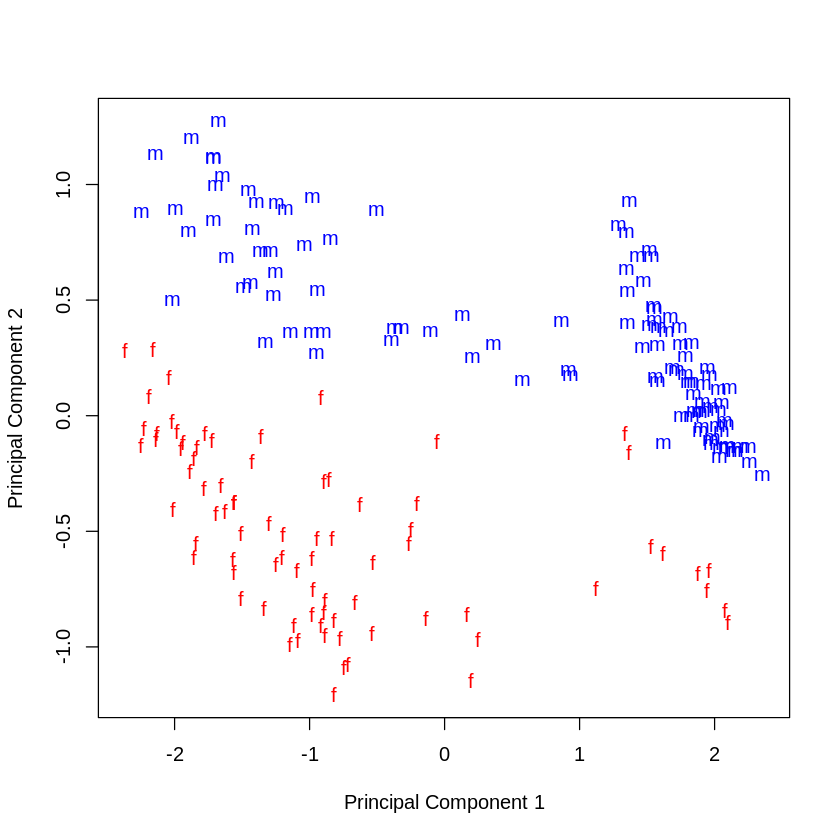

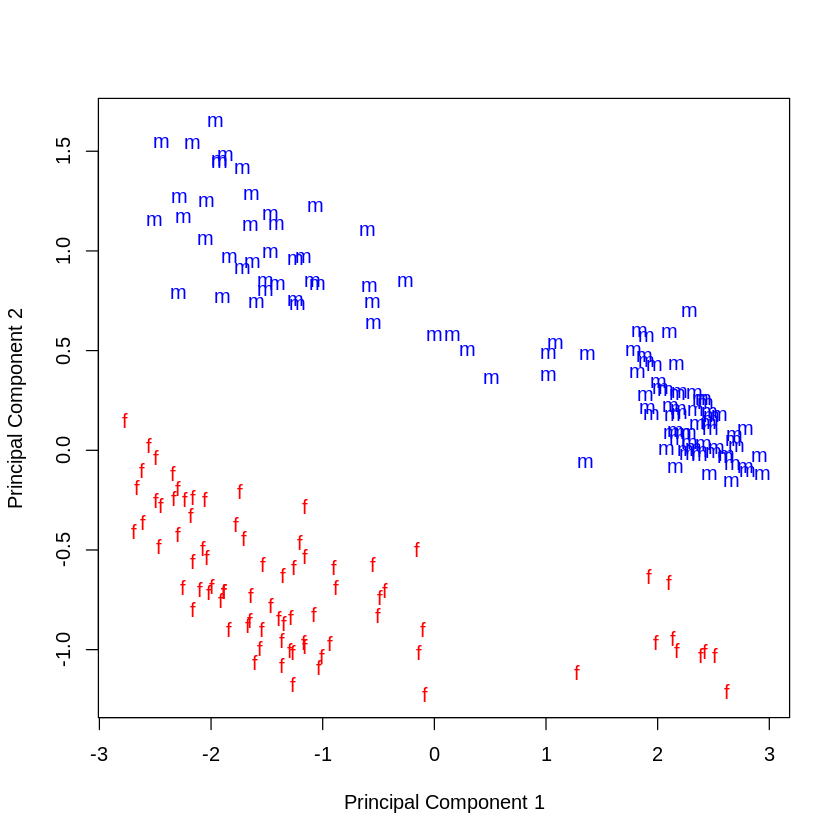

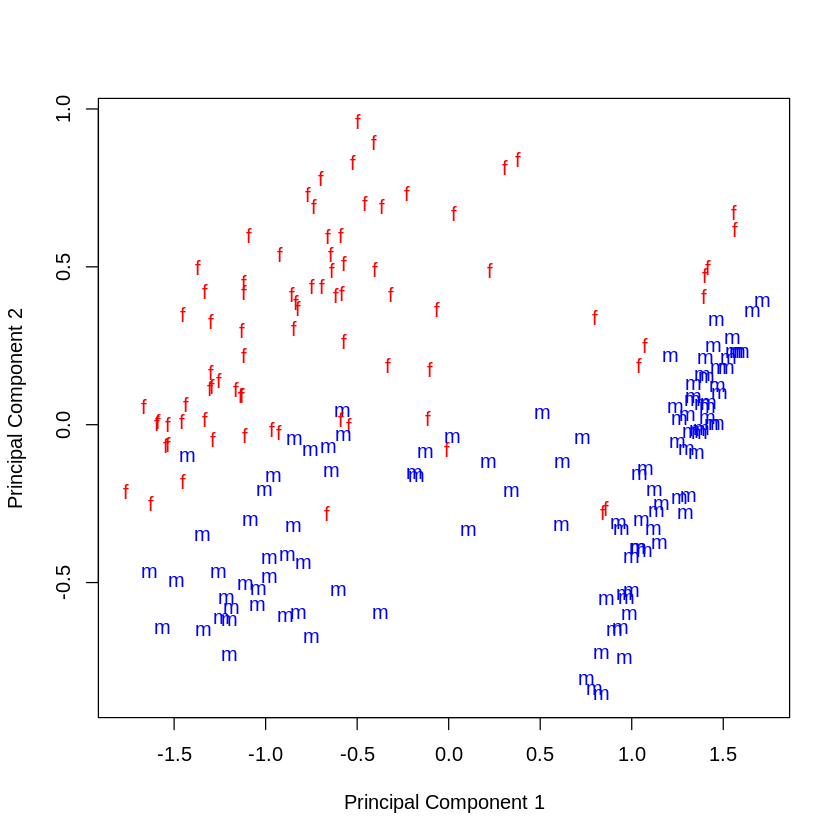

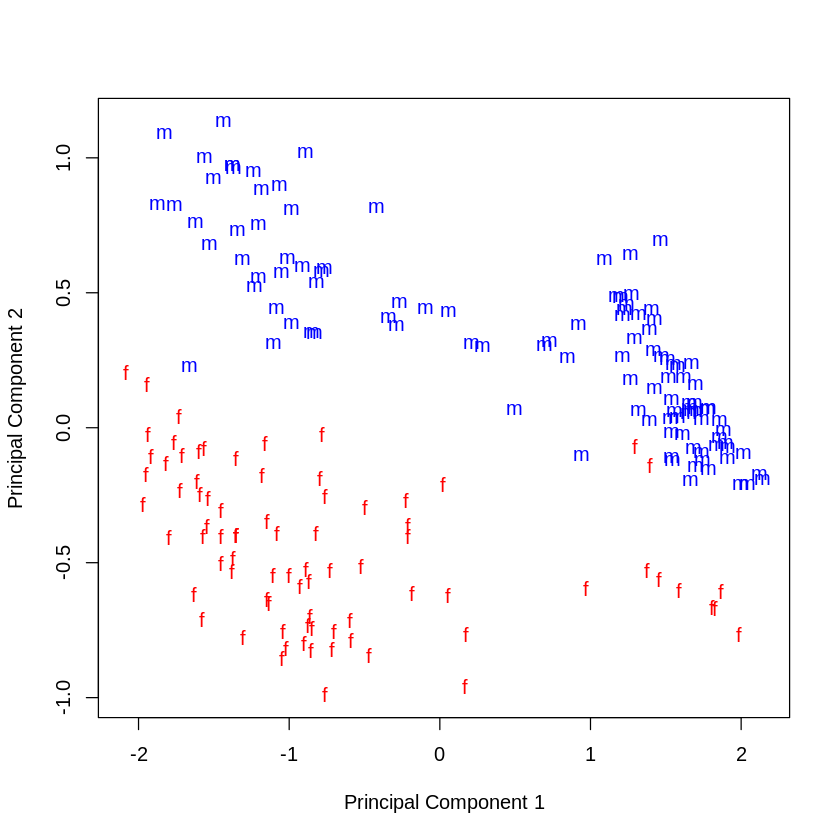

In [21]:
sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))

design    <- model.matrix ( ~ sex)
y <- DGEList(counts=ijc, group = sex)
y <- calcNormFactors(y, method="upperquartile")
y_voom <- voom (y, design=design)
Gender <- substring(sex,1,1)
plotMDS(y, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

### SJC
sjc counts are skipped exon junction counts -- ijc counts hold together for the top 1000, the skipped exon junction counts fall appart
at a lower number -- around 200!  separation fails between the genders at 250

In [ ]:
sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))
design    <- model.matrix(~ sex)
y <- DGEList(counts=sjc, group = sex)
y <- calcNormFactors(y, method="upperquartile")
y_voom <- voom (y, design=design)

Gender <- substring(sex,1,1)
plotMDS(y, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y, labels=Gender, top=700, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=700, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

## Differential analysis as_event:ijc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject.

In [ ]:
sex       <- reduced.meta.data$sex

design    <- model.matrix( ~ sex )

colnames(design) <- c("intercept","sex")

dim(ijc)
table(sex)
head(design)

y_ijc <- DGEList(counts=ijc, group = sex)
y_ijc <- calcNormFactors(y_ijc, method="upperquartile")

y_ijc_voom <- voom (y_ijc, design=design)

Gender <- substring(sex,1,1)

plotMDS(y_ijc, labels=Gender, top=1000, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

plotMDS(y_ijc_voom, labels=Gender, top=1000, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

fit_ijc <- lmFit(y_ijc_voom, design)
fit_ijc <- eBayes(fit_ijc)

ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_voom))
ijc_sex_results_refined  <- ijc_sex_results$adj.P.Val < 0.05 & abs(ijc_sex_results$logFC) > 1.5

table(ijc_sex_results_refined)

## Differential analysis as_event:sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the excluded exon junction count (sjc) expression; sex denotes the reported sex of the subject.

In [ ]:
sex       <- reduced.meta.data$sex

design    <- model.matrix( ~ sex )

colnames(design) <- c("intercept","sex")

dim(sjc)
table(sex)
head(design)

y_sjc <- DGEList(counts=sjc, group = sex)
y_sjc <- calcNormFactors(y_sjc, method="upperquartile")

y_sjc_voom <- voom (y_sjc, design=design)

Gender <- substring(sex,1,1)

plotMDS(y_sjc, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

plotMDS(y_sjc_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

fit_sjc <- lmFit(y_sjc_voom, design)
fit_sjc <- eBayes(fit_sjc)

sjc_sex_results          <- topTable(fit_sjc, coef='sex', number=nrow(y_voom))
sjc_sex_results_refined  <- sjc_sex_results$adj.P.Val < 0.05 & abs(sjc_sex_results$logFC) > 1.5

table(sjc_sex_results_refined)

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.   Donor is added to our model as a blocking variable used in both the calculation of duplicate correlation as well as in the linear fit.

In [ ]:
ijc_names    <- as.character(colnames(ijc))
sjc_names    <- as.character(colnames(sjc))
sample_names <- as.character(colnames(ijc))

ijc_names <- paste0(ijc_names,"-ijc")
sjc_names <- paste0(sjc_names,"-sjc")
colnames(ijc) <- ijc_names
colnames(sjc) <- sjc_names

as_matrix <- cbind(ijc,sjc)
sex       <- c(rep(reduced.meta.data$sex,2))
sex       <- factor(sex, levels=c('male','female'))
as_event  <- c(rep("ijc",dim(ijc)[2]), rep("sjc", dim(sjc)[2]))
as_event  <- factor(as_event, levels=c("ijc", "sjc"))

# we will add donor as a blocking parameter
donor    <- rep(sample_names, 2)

design    <- model.matrix( ~ sex + as_event + sex*as_event )

colnames(design) <- c("intercept","sex","as_event","sex*as_event")

dim(as_matrix)
table(sex)
table(as_event)
head(design)

### Voom, limma's lmFit and eBayes

Using sample as a blocking variable, we are able to model the effects of the donor on the results, which improves the power.  This topic is discussed in biostars https://www.biostars.org/p/54565/.  And Gordon Smyth answers the question here https://mailman.stat.ethz.ch/pipermail/bioconductor/2014-February/057887.html.  The method of modeling is a random effects approach in which the intra-donor correlation is incorporated into the covariance matrix instead of the linear predictor.   And though as Gordon Smyth states both are good method and the twoway anova approach makes fewer assumptions, the random effects approach is statistically more powerful.  

We have a balanced design in which all donors receive all stimuli (which is really in healthy human donors, life and all of its factors!) Our measurement has so many points -- we are measuring in the skipped exon approach, 42,611 junctions!   It is not possible to encorporate those measurements into the linear predictor.  A two-way ANOVA approach is virtually as powerful as the random effects approach 
and hence is preferable as it makes fewer assumptions.

For an unbalanced design in which each donor receives only a subset of the stimula, the random effects approach is more powerful.

Random effects approach is equivalent to The first method is twoway anova, a generalization of a paired analysis.


In [ ]:
# we will model as random effects, represented as a block
donor    <- rep(sample_names, 2)
length(donor)

In [27]:
y <- DGEList(counts=as_matrix, group = sex)
y <- calcNormFactors(y, method="upperquartile")
y_voom <- voom (y, design=design)

dup_cor <- duplicateCorrelation(y_voom$E, design=design, ndups=2, block=donor, weights=y$samples$norm.factors)
dup_cor$consensus.correlation

[1] 0.1859776

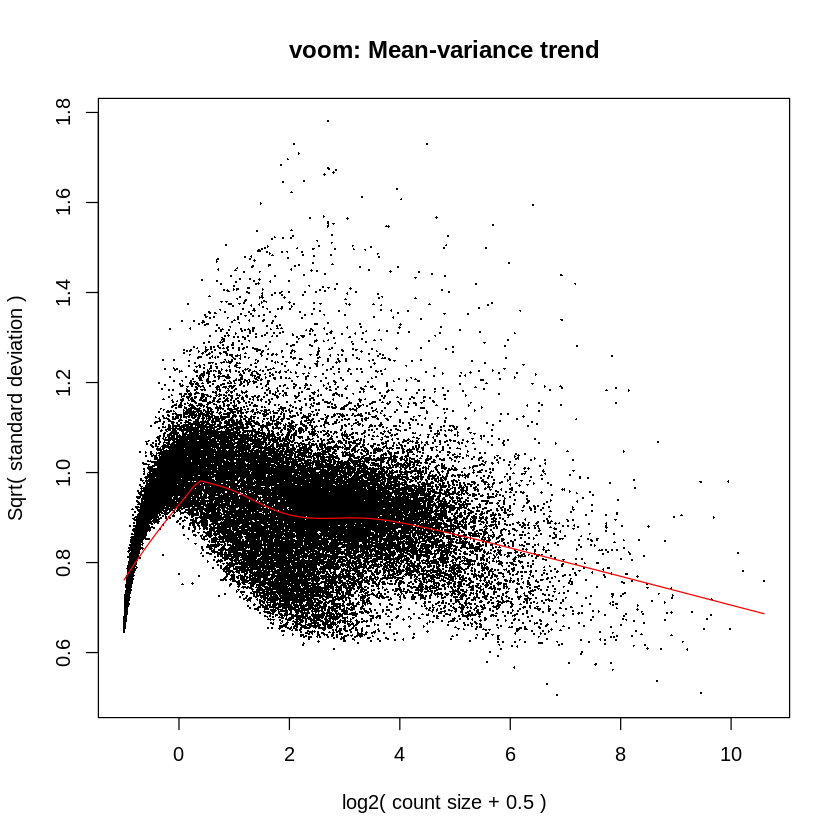

In [28]:
y_dup_voom <- voom (y, design=design, plot = TRUE, block = donor, correlation = dup_cor$consensus.correlation)

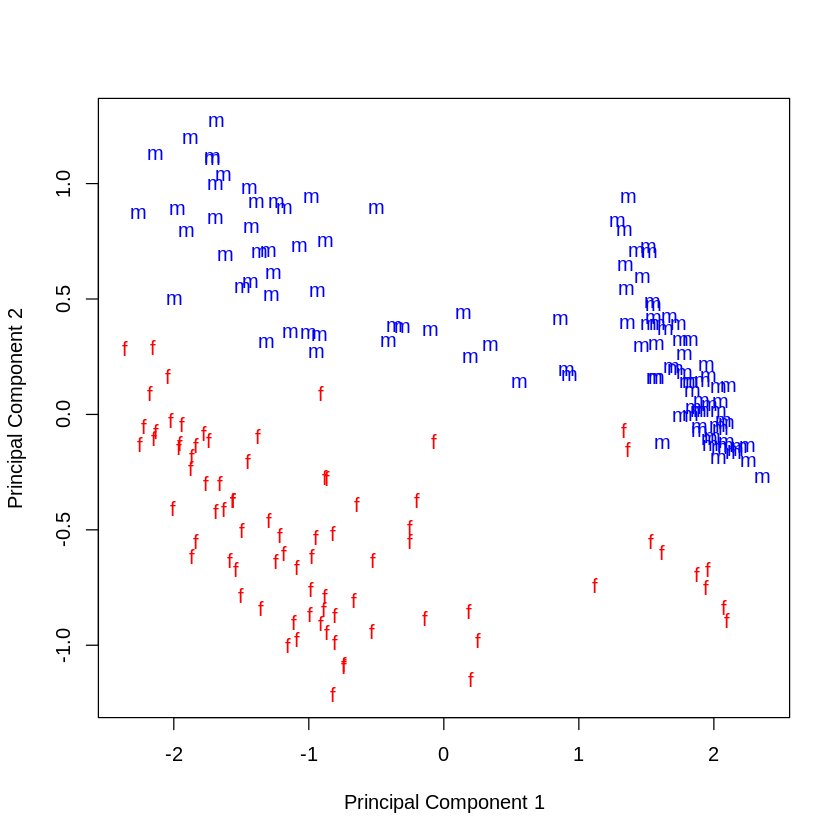

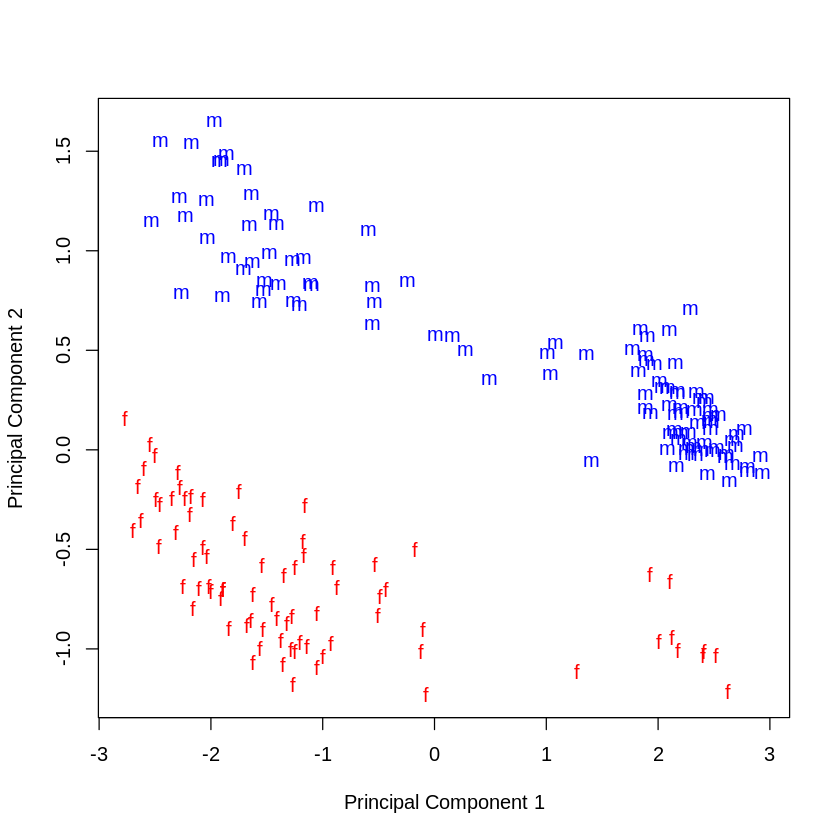

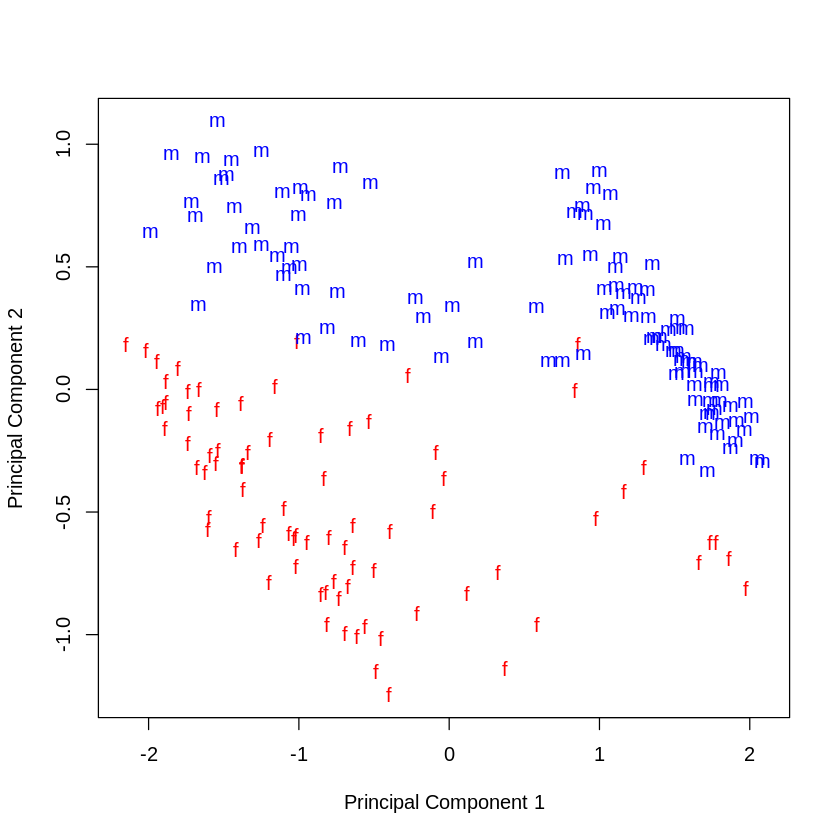

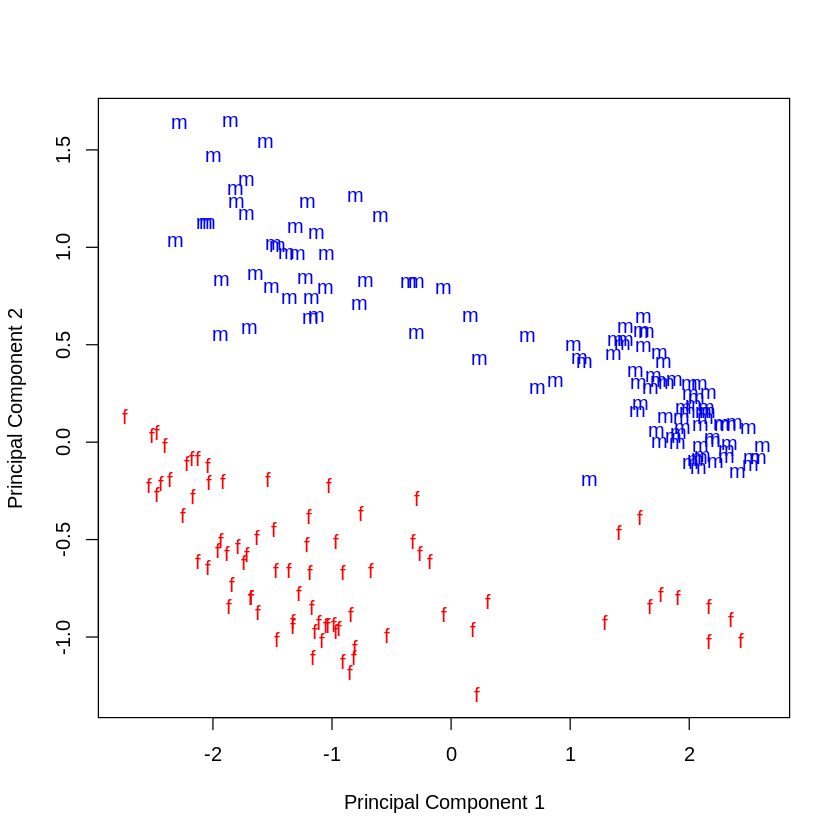

In [29]:
Gender <- substring(sex[1:dim(ijc)[2]],1,1)

plotMDS(y[,c(1:dim(ijc)[2])], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom[,c(1:dim(ijc)[2])], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_dup_voom[,c(1:dim(ijc)[2])], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y[,c((dim(ijc)[2]+1)):(dim(ijc)[2]+dim(sjc)[2])], labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom[,c((dim(ijc)[2]+1)):(dim(ijc)[2]+dim(sjc)[2])], labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_dup_voom[,c((dim(ijc)[2]+1):(dim(ijc)[2]+dim(sjc)[2]))], labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

In [30]:
fit <- lmFit(y_dup_voom, design=design, block=donor, correlation = dup_cor$consensus.correlation)
fit <- eBayes(fit, robust=TRUE)

In [31]:
sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_voom))
sex_as_events_results_refined <- sex_as_events_results$adj.P.Val < 0.05 & abs(sex_as_events_results$logFC) > 1.5

sex_results                   <- topTable(fit, coef="sex", number=nrow(y_voom))
sex_results_refined           <- sex_results$adj.P.Val < 0.05 & abs(sex_results$logFC) > 1.5

table(sex_as_events_results_refined)
table(sex_results_refined)

sex_as_events_results_refined
FALSE  TRUE 
42200   411 

sex_results_refined
FALSE  TRUE 
42203   408 

#### fromGTF

rMATS analyzes the gtf file and determines the junctions, identifying 10 matrices in all.  The fromGTF.SE.txt contains the annotation information and we can use this information to estimate the duplicate correlation effect from counting based upon the same gene with our ijc counts.  we will use this information, to obtain the gene information.


In [32]:
# fromGTF.tar.gz
if (! (file.exists("../data/fromGTF.tar.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching fromGTF.tar.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.*.txt.gz into ../data")
    system("gunzip  ../data/fromGTF*.txt.gz ", intern = TRUE)
    message("Done!\n")
}
fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
head(fromGTF.SE)
genes <- factor(fromGTF.SE$geneSymbol)
length(levels(genes))

Fetching fromGTF.tar.gz from GitHub ..

downloading fromGTF.tar.gz ...



  |======================================================================| 100%


Done!


Decompressing fromGTF.tar.gz into ../data

Done!


Decompressing fromGTF.*.txt.gz into ../data

Done!




,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769
2,2,ENSG00000034152.18,MAP2K3,chr17,+,21303182,21303234,21302142,21302259,21304425,21304553
3,3,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21296085,21296143
4,4,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21298412,21298479
5,5,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21296085,21296143
6,6,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21298412,21298479


[1] 13390

In [33]:
head(sex_as_events_results)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19076,5.882004,0.4623452,59.93929,3.249431e-198,1.384615e-193,432.7360
5965,6.095896,0.5974117,58.21383,8.730492e-194,1.860075e-189,423.1656
19070,5.434536,0.3502684,55.61250,6.602101e-187,9.377404e-183,408.1777
5962,5.908174,0.6820468,50.96963,5.496989e-174,5.855805e-170,380.0420
6300,5.497805,0.7601863,43.29996,1.270316e-150,1.082589e-146,328.4099
34357,5.636847,1.4625119,42.43349,8.258637e-148,5.865146e-144,321.4354


In [34]:
# index to the annotations - these are the Junction IDs
sex_as_events_rnResults <- rownames(sex_as_events_results)
sex_rnResults           <- rownames(sex_results)
ijc_sex_rnResults       <- rownames(ijc_sex_results)
sjc_sex_rnResults       <- rownames(sjc_sex_results)
head(sex_as_events_rnResults)
head(ijc_sex_rnResults)
head(sjc_sex_rnResults)
head(sex_rnResults)
head(fromGTF.SE[sex_as_events_rnResults,])

[1] "19076" "5965"  "19070" "5962"  "6300"  "34357"

[1] "19070" "19076" "5965"  "34357" "5962"  "6300"

[1] "28712" "5964"  "10150" "19072" "10152" "10151"

[1] "10150" "19076" "5965"  "34357" "5963"  "19070"

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105


In [35]:
# use the junctionIDs to get the annotations
sex_as_events_resultsAnnotations      <- fromGTF.SE[sex_as_events_rnResults,]
sex_resultsAnnotations                <- fromGTF.SE[sex_rnResults,]
ijc_sex_resultsAnnotations            <- fromGTF.SE[ijc_sex_rnResults,]
sjc_sex_resultsAnnotations            <- fromGTF.SE[sjc_sex_rnResults,]
head(sex_as_events_resultsAnnotations)
head(sex_resultsAnnotations)
head(ijc_sex_resultsAnnotations)
head(sjc_sex_resultsAnnotations)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
5963,5963,ENSG00000012817.15,KDM5D,chrY,-,19739527,19739662,19735620,19735750,19741317,19741488
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
28712,28712,ENSG00000131002.12,TXLNGY,chrY,+,19598551,19598639,19597356,19597665,19599738,19599831
5964,5964,ENSG00000012817.15,KDM5D,chrY,-,19723340,19723433,19721129,19721311,19731771,19731930
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
19072,19072,ENSG00000183878.15,UTY,chrY,-,13354785,13354833,13335562,13336335,13355002,13355398
10152,10152,ENSG00000229807.11,XIST,chrX,-,73830622,73830790,73829067,73829231,73831065,73831210
10151,10151,ENSG00000229807.11,XIST,chrX,-,73822070,73822233,73820655,73821029,73826114,73826301


In [36]:
sex_as_events_results_refinedAnnotations<- sex_as_events_resultsAnnotations[sex_as_events_results_refined==TRUE,]
sex_results_refinedAnnotations          <- sex_resultsAnnotations          [sex_results_refined          ==TRUE,]
ijc_sex_results_refinedAnnotations      <- ijc_sex_resultsAnnotations      [ijc_sex_results_refined      ==TRUE,]
sjc_sex_results_refinedAnnotations      <- sjc_sex_resultsAnnotations      [sjc_sex_results_refined      ==TRUE,]
head(sex_as_events_results_refinedAnnotations)
head(sex_results_refinedAnnotations)
head(ijc_sex_results_refinedAnnotations)
head(sjc_sex_results_refinedAnnotations)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
5963,5963,ENSG00000012817.15,KDM5D,chrY,-,19739527,19739662,19735620,19735750,19741317,19741488
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
28712,28712,ENSG00000131002.12,TXLNGY,chrY,+,19598551,19598639,19597356,19597665,19599738,19599831
5964,5964,ENSG00000012817.15,KDM5D,chrY,-,19723340,19723433,19721129,19721311,19731771,19731930
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
19072,19072,ENSG00000183878.15,UTY,chrY,-,13354785,13354833,13335562,13336335,13355002,13355398
10152,10152,ENSG00000229807.11,XIST,chrX,-,73830622,73830790,73829067,73829231,73831065,73831210
10151,10151,ENSG00000229807.11,XIST,chrX,-,73822070,73822233,73820655,73821029,73826114,73826301


In [37]:

# geneSymbols are in the annotations
sex_as_events_geneSymbols         <- sex_as_events_resultsAnnotations$geneSymbol
sex_geneSymbols                   <- sex_resultsAnnotations$geneSymbol
ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol

sex_as_events_refined_geneSymbols <- sex_as_events_results_refinedAnnotations$geneSymbol
sex_refined_geneSymbols           <- sex_results_refinedAnnotations$geneSymbol
ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol

# adjust the rownames to be the geneSymbols rather than junction IDs
sex_as_events_results_rn   <- paste(sex_as_events_geneSymbols, sex_as_events_rnResults, sep="-")
sex_results_rn             <- paste(sex_geneSymbols,           sex_rnResults, sep="-")
ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")

head(sex_as_events_results_rn)
head(sex_results_rn)
head(ijc_sex_results_rn)
head(sjc_sex_results_rn)


[1] "UTY-19076"    "KDM5D-5965"   "UTY-19070"    "KDM5D-5962"   "USP9Y-6300"  
[6] "EIF1AY-34357"

[1] "XIST-10150"   "UTY-19076"    "KDM5D-5965"   "EIF1AY-34357" "KDM5D-5963"  
[6] "UTY-19070"

[1] "UTY-19070"    "UTY-19076"    "KDM5D-5965"   "EIF1AY-34357" "KDM5D-5962"  
[6] "USP9Y-6300"

[1] "TXLNGY-28712" "KDM5D-5964"   "XIST-10150"   "UTY-19072"    "XIST-10152"  
[6] "XIST-10151"

In [38]:
rownames(sex_as_events_results) <- sex_as_events_results_rn
rownames(sex_results)           <- sex_results_rn
rownames(ijc_sex_results)       <- ijc_sex_results_rn
rownames(sjc_sex_results)       <- sjc_sex_results_rn

In [39]:
sex_as_events_filename         = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_as_events.csv',sep='')
sex_filename                   = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex.csv',sep='')
ijc_sex_filename               = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_ijc_sex.csv',sep='')
sjc_sex_filename               = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sjc_sex.csv',sep='')

sex_as_events_refined_filename = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_as_events_refined.csv',sep='')
sex_refined_filename           = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_refined.csv',sep='')
ijc_sex_refined_filename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_ijc_sex_refined.csv',sep='')
sjc_sex_refined_filename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sjc_sex_refined.csv',sep='')

sex_as_events_genesFilename    = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_as_events_universe.txt',sep='')
sex_genesFilename              = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_universe.txt',sep='')
ijc_sex_genesFilename          = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_ijc_sex_universe.txt',sep='')
sjc_sex_genesFilename          = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sjc_sex_universe.txt',sep='')

sex_as_events_refined_genesFilename = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_as_events_gene_set.txt',sep='')
sex_refined_genesFilename           = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_gene_set.txt',sep='')
ijc_sex_refined_genesFilename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_ijc_sex_gene_set.txt',sep='')
sjc_sex_refined_genesFilename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sjc_sex_gene_set.txt',sep='')


In [40]:
write.table(sex_as_events_results, file = sex_as_events_filename, row.names = T, col.names = T, quote = F, sep = ",")
write.table(sex_results,           file = sex_filename          , row.names = T, col.names = T, quote = F, sep = ",")
write.table(ijc_sex_results,       file = ijc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")
write.table(sjc_sex_results,       file = sjc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")

write.table(sex_as_events_results[sex_as_events_results_refined,], file = sex_as_events_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
write.table(sex_results          [sex_results_refined          ,], file = sex_refined_filename          , row.names = T, col.names = T, quote = F, sep = ",")
write.table(ijc_sex_results      [ijc_sex_results_refined      ,], file = ijc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")
write.table(sjc_sex_results      [sjc_sex_results_refined      ,], file = sjc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")

write.table(sex_as_events_geneSymbols, file = sex_as_events_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
write.table(sex_geneSymbols,           file = sex_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
write.table(ijc_sex_geneSymbols,       file = ijc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")
write.table(sjc_sex_geneSymbols,       file = sjc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

write.table(sex_as_events_refined_geneSymbols,file = sex_as_events_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
write.table(sex_refined_geneSymbols,          file = sex_refined_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
write.table(ijc_sex_refined_geneSymbols,      file = ijc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")
write.table(sjc_sex_refined_geneSymbols,      file = sjc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [41]:
notebookid   = "BreastMammaryTissueJunctionAnalysis"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 



character(0)

Done!




sha256sum,file
<chr>,<chr>
ccf16742fe3db84abc66404b4c50981e6dee33b0de3f481111a2b44f6f931813,./BreastMammaryTissue_DGE_ijc_sex.csv
d9b424c4c6a3084bf89e21ee0c0a806a882f0dac448b3c0bf61c8bfe1b002f58,./BreastMammaryTissue_sex_as_events_universe.txt
741763f61d32c98446317ad30c45cdb3199039b0c696ab83461eb91b0e8611fe,./BreastMammaryTissue_DGE_sjc_sex.csv
28764f9f1e0f14e399d555e448b5490c7221454e7d34d220f79b537376ca017b,./fromGTF.novelEvents.SE.txt
e532e4d8ee0f5e5ba221017a1c07c5b1376f7d711aacbba5cc713badd8bd3e47,./BreastMammaryTissue_ijc_sex_universe.txt
fb7fced98c23d7f0e69f820a8cf1616c3a2a88386074ae5a14690f313ae210d0,./BreastMammaryTissue_sjc_sex_universe.txt
b408d18141c7de21b42d5fa78e442e482d6c249b90b45800271f5124c11dd3d3,./BreastMammaryTissue_sex_gene_set.txt
5146c849c9354129590c59da5e6040a074523b4827d0975e3f5fa43737af7e9a,./README.md
efe91f83b5b3d4a6497e7265979ec2616f1e330005b3117fbd6e0da0c4b37c79,./BreastMammaryTissue_DGE_sjc_sex_refined.csv


### 2. Libraries metadata

In [42]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.2 (2019-12-12)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-13                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.2,3.42.2,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2020-02-03,Bioconductor,NA,/opt/conda/lib/R/library
multtest,multtest,2.42.0,2.42.0,/opt/conda/lib/R/library/multtest,/opt/conda/lib/R/library/multtest,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
piggyback,piggyback,0.0.10.99,0.0.10.99,/opt/conda/lib/R/library/piggyback,/opt/conda/lib/R/library/piggyback,TRUE,FALSE,2020-05-13,Github (ropensci/piggyback@87f71e8),NA,/opt/conda/lib/R/library
R.methodsS3,R.methodsS3,1.8.0,1.8.0,/opt/conda/lib/R/library/R.methodsS3,/opt/conda/lib/R/library/R.methodsS3,TRUE,FALSE,2020-02-14,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
R.oo,R.oo,1.23.0,1.23.0,/opt/conda/lib/R/library/R.oo,/opt/conda/lib/R/library/R.oo,TRUE,FALSE,2019-11-03,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
R.utils,R.utils,2.9.2,2.9.2,/opt/conda/lib/R/library/R.utils,/opt/conda/lib/R/library/R.utils,TRUE,FALSE,2019-12-08,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
